In [12]:
import FinanceDataReader as fdr
import pandas as pd
import os
from datetime import datetime
from dateutil.relativedelta import relativedelta


In [6]:
f = '/home/choi/airflow/dags/database/symbol_data/korea_stock_symbols_2024-03-12.csv'
d = pd.read_csv(f)

In [11]:
for _, s in d.iterrows():
    code = s['value'].split(':')[1]
    print(code)
    break

005930


In [12]:
import exchange_calendars as ecals

In [9]:
x = datetime.datetime.strptime('2024-01-01','%Y-%m-%d')

In [11]:
x = x + relativedelta(days=1)
x

datetime.datetime(2024, 1, 2, 0, 0)

In [6]:

today = datetime.datetime.now()
bef = today - relativedelta(months=3)
bef_str = bef.strftime("%Y-%m-%d")
today_str = today.strftime("%Y-%m-%d")

In [13]:
XKRX = ecals.get_calendar("XKRX")

In [16]:
XKRX.is_session('2024-01-01')

False

In [20]:
def valid_latest_day(day):
    XKRX = ecals.get_calendar("XKRX")

    day = today

    while not XKRX.is_session(day.strftime("%Y-%m-%d")):
        day = day - datetime.timedelta(days=1)
    return  day.strftime("%Y-%m-%d")
    # 이거는 AirFlow에서 할 수 있게 만드면 됨
    # -> 데이터 확인할 떄는 마지막 열에 있는지만 확인

In [21]:
valid_latest_day()

'2024-03-13'

In [13]:
stocks = fdr.StockListing('KOSPI')[['Code','Name']]
for code in stocks['Code']:
    break
df

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2024-03-13,8530,8530,8100,8480,123,-0.007026


In [18]:
import time

In [23]:
df = fdr.DataReader(code,"2024-03-12", "2024-03-12").iloc[0]['Close']
df

73300.0

In [30]:
import yfinance as yf

In [38]:
import numpy as np

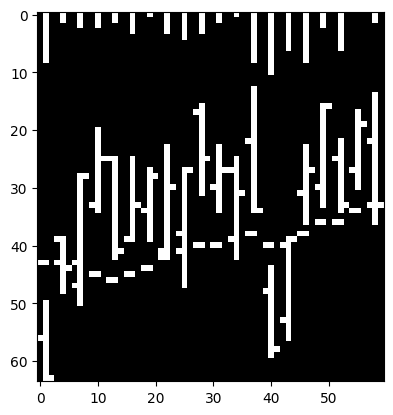

In [41]:
window_size = 20
df = fdr.DataReader(code)[-39:]
df[f'MA'] = df['Close'].rolling(window_size).mean()
df.dropna(inplace=True)
df

price_slice = df[:][['Open', 'High', 'Low', 'Close']+['MA']].reset_index(drop=True)
volume_slice = df[:][['Volume']].reset_index(drop=True)

price_slice = (price_slice - np.min(price_slice.values))/(np.max(price_slice.values) - np.min(price_slice.values))
price_slice[np.isnan(price_slice)] = 0.5

volume_slice = (volume_slice - np.min(volume_slice.values))/(np.max(volume_slice.values) - np.min(volume_slice.values))
volume_slice[np.isnan(volume_slice)] = 0

price_slice = price_slice.apply(lambda x: x*(51-1)+13).astype(int)
volume_slice = volume_slice.apply(lambda x: x*(12-1)).astype(int)

image = np.zeros((64, window_size*3))
for i in range(len(price_slice)):
    # 캔들 그래프
    image[price_slice.loc[i]['Open'], i*3] = 255.
    image[price_slice.loc[i]['Low']:price_slice.loc[i]['High']+1, i*3+1] = 255.
    image[price_slice.loc[i]['Close'], i*3+2] = 255.
    # 이동 평균선
    image[price_slice.loc[i]['MA'], i*3:i*3+2] = 255.
    # 거래량
    image[:volume_slice.loc[i]['Volume'], i*3+1] = 255.

# image = np.flipud(image).copy()
import matplotlib.pyplot as plt
plt.imshow(image,cmap='grey')

In [19]:
stocks = fdr.StockListing('KOSPI')[['Code','Name']]
stocks

,Code,Name
0,005930,삼성전자
1,000660,SK하이닉스
2,373220,LG에너지솔루션
3,207940,삼성바이오로직스
4,005380,현대차
...,...,...
948,002787,진흥기업2우B
949,002785,진흥기업우B
950,002995,금호건설우
951,001525,동양우


In [3]:
import FinanceDataReader as fdr
import pandas as pd
import os
import datetime
from dateutil.relativedelta import relativedelta
stocks = fdr.StockListing('KOSPI')[['Code','Name']]
for code in stocks['Code']:
    break

In [5]:
fdr.DataReader(code)

,Open,High,Low,Close,Volume,Change
Date,,,,,,
1999-11-19,4630,4720,4550,4640,682900,NaN
1999-11-22,4640,4640,4500,4520,577591,-0.025862
1999-11-23,4520,4600,4440,4440,571893,-0.017699
1999-11-24,4460,4540,4400,4530,501773,0.020270
1999-11-25,4600,4600,4450,4450,588443,-0.017660
...,...,...,...,...,...,...
2024-03-07,73100,73300,72200,72200,14516963,-0.009602
2024-03-08,72800,73400,72600,73300,19271349,0.015235
2024-03-11,72900,73100,72300,72400,9740504,-0.012278


In [2]:
import model

In [3]:
x = model.inference(code)

In [2]:
from datetime import timedelta, datetime
date = "{{ ds }}"
execution_date = datetime.strptime(date, "%Y-%m-%d").date()
execution_date

ValueError: time data '{{ ds }}' does not match format '%Y-%m-%d'

In [10]:
x = x[0]

In [1]:
{{ ds }}

NameError: name 'ds' is not defined

In [7]:
import torch

In [11]:
torch.argmax(x).item()

0

In [ ]:
# Airflow PipeLine
하루마다 (밤 12시 시작)


# Airflow PipeLine
1. 자정 시작
2. 오늘 날짜가 개장일인지 확인 -> 아니면 Flow 작동 X
3. 해당 날짜가 개장 날짜인 경우만 작동

4-0. 종목 코드 불러와서 유효한지 확인
4-1. (종목 코드 : 이름) DB 저장
4-2. 유효한 경우


In [24]:
import FinanceDataReader as fdr
import pandas as pd

In [25]:
kospi_list = fdr.StockListing('KOSPI')
kosdaq_list = fdr.StockListing('KOSDAQ')

korea_stock_list = pd.concat([kospi_list, kosdaq_list])

In [26]:
korea_stock_symbol = korea_stock_list[['Code', 'Name']]

In [27]:
korea_stock_symbol.iloc[0]['Code']

'005930'

In [28]:
valid_stocks = pd.DataFrame(columns=['Code', 'Name'])
valid_stocks

,Code,Name


In [79]:
valid_stocks

,Code,Name


In [4]:
for _,stock in korea_stock_symbol.iterrows():
    code, name = stock['Code'], stock['Name']
    df = fdr.DataReader(code,"2024-03-13")
    if "2024-03-13" in df.index: # 유효한 경우
        pass
        # valid_stocks = pd.concat([valid_stocks, pd.DataFrame({'Code': code, 'Name': name})]) 
    else:
        print("1")

In [31]:
korea_stock_symbol['Code'] = 'KRX:' + korea_stock_symbol['Code']
korea_stock_symbol

/tmp/ipykernel_10188/1703222212.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  korea_stock_symbol['Code'] = 'KRX:' + korea_stock_symbol['Code']


,Code,Name
0,KRX:005930,삼성전자
1,KRX:000660,SK하이닉스
2,KRX:373220,LG에너지솔루션
3,KRX:207940,삼성바이오로직스
4,KRX:005380,현대차
...,...,...
1713,KRX:161570,THE MIDONG
1714,KRX:413600,키움제6호스팩
1715,KRX:438580,엔에이치스팩25호
1716,KRX:032685,소프트센우


In [35]:
df = pd.DataFrame(columns=['Date', 'Name', 'Code', 'Close_Price', 'Day_1', 'Day_2', 'Day_3', 'Day_4', 'Day_5', 'Day_6', 'Day_7'])

In [39]:
pd.Series(rs, index=df.columns)

Date             2024
Name            naver
Code             0231
Close_Price    453245
Day_1          0/54.3
Day_2          0/54.3
Day_3          0/54.3
Day_4          0/54.3
Day_5          0/54.3
Day_6          0/54.3
Day_7          0/54.3
dtype: object

In [44]:
list(df.columns)

['Date',
 'Name',
 'Code',
 'Close_Price',
 'Day_1',
 'Day_2',
 'Day_3',
 'Day_4',
 'Day_5',
 'Day_6',
 'Day_7']

In [48]:
df

,Date,Name,Code,Close_Price,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Day_7


In [65]:
len(rs)

11

In [64]:
len(list(df.columns))

11

ValueError: Shape of passed values is (11, 1), indices imply (11, 11)

In [69]:
rs = ["2024","naver","0231",453245,"0/54.3","0/54.3","0/54.3","0/54.3","0/54.3","0/54.3","0/54.3"]

df = pd.concat([df, pd.DataFrame([rs], columns=list(df.columns))])
df

,Date,Name,Code,Close_Price,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Day_7
0,2024,naver,0231,453245,0/54.3,0/54.3,0/54.3,0/54.3,0/54.3,0/54.3,0/54.3
